# Purpose of Experiment and Introduction

This experiment is the implementation of Deepayan Das's "Adapting OCR with limited supervision" framework, as highlighted in the GitHub repository [Adapting-OCR](https://github.com/Deepayan137/Adapting-OCR), adapted to function with Francesco Pettini's License Plate Characters dataset, available on [Kaggle](https://www.kaggle.com/datasets/francescopettini/license-plate-characters-detection-ocr).

The objective of this experiment is to improve the basic implementation's lacking performance. This will be done primarily through data augmentation, thus doubling the amount of data that it's available for training and testing the model, not just that but the model's architecture has been changed by adding a residual block layer, deepening the neural network by adding a new layer and changing the kernel and padding sizes and channel numbers.


In [1]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *

Firstly, the data-augmentation functions are implemented, they use the bounding box coordinates found in the associated `.xml` files. This way the images are recreated with randomized transformations applied towards the characters, pertaining to their rotation, color (which is not entirely redundant as if the image is transformed to grayscale, each color code has a different grayscale corresponding "color") and contrast.

The cell below is strictly for debugging purposes and for demonstrating the augmentation function's capability.

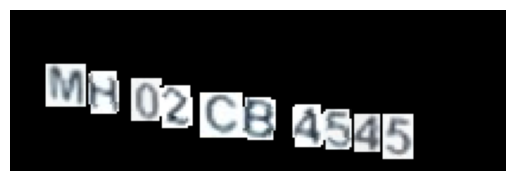

In [2]:
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import xml.etree.ElementTree as ET
import random

def augment_character(char_img):
    # Augmentations
    char_img = char_img.rotate(random.uniform(-10, 10))  # Random rotation
    char_img = ImageEnhance.Color(char_img).enhance(random.uniform(0.8, 1.2))  # Random color adjustment
    char_img = ImageEnhance.Contrast(char_img).enhance(random.uniform(0.8, 1.2))  # Random contrast adjustment
    return char_img

def augment_image(img_path, xml_path):
    img = Image.open(img_path)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    new_img = Image.new('RGB', img.size)
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin, ymin, xmax, ymax = map(int, [bndbox.find(tag).text for tag in ['xmin', 'ymin', 'xmax', 'ymax']])
        char_img = img.crop((xmin, ymin, xmax, ymax))
        char_img = augment_character(char_img)
        new_img.paste(char_img, (xmin, ymin))

    return new_img  # This is your augmented image

# Usage:
augmented_image = augment_image('./dataset/LP-characters/images/0001.png', './dataset/LP-characters/annotations/0001.xml')

# Display the image using Matplotlib as how the data would look within the dataset
plt.imshow(augmented_image, cmap='gray')  # Using cmap='gray' for grayscale images so that it would replicate the later transformation
plt.axis('off')
plt.show()

Data quality assurance purposes I began by creating a function which restores and displays the images loaded in the dataset by undoing the transformations done upon it (which are hardcoded but can be easilly changed selectively)

In [3]:
from matplotlib import pyplot as plt

# Helper function that I use to check if the images and labels are correctly loaded into the dataset class
def imshow(img, title=None):
    # Converting from Torch tensor to numpy array
    img = img.numpy().transpose((1, 2, 0))
    # Undoing normalization
    mean = 0.5
    std = 0.5
    img = std * img + mean
    img = img.clip(0, 1)  # Clip values to be between 0 and 1
    plt.imshow(img, cmap='gray' if len(img.shape)==2 else None)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pausing to update the plots

Removed the resizing from the collator as it was redundant and it was kept in the previous iteration to highlight a user error.

In [4]:
class SynthCollator(object):
    def __call__(self, batch):
        imgs = [item['img'] for item in batch]
        augmented_imgs = [item['augmented_img'] for item in batch]
        
        imgs = torch.stack(imgs, 0)
        augmented_imgs = torch.stack(augmented_imgs, 0)
        
        indexes = [item['idx'] for item in batch]
        
        item = {'img': imgs, 'augmented_img': augmented_imgs, 'idx': indexes}
        
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        
        return item



The SynthDataset class is modified to account for each image's augmented image counterpart, this way both the original image and the augmented one retain the same label. The resizing dimensions have been increased, to extract as much information as possible from a larger amount of pixels.

In [5]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random
from PIL import Image, ImageEnhance
import xml.etree.ElementTree as ET

class SynthDataset(Dataset):
    def __init__(self, opt, train=True):
        super(SynthDataset, self).__init__()
        
        # Loading images
        self.img_dir = os.path.join(opt['path'], opt['imgdir'])
        
        # Loading annotations
        self.anno_dir = os.path.join(opt['path'], 'annotations')
        
        self.images = os.listdir(self.img_dir)
        
        # Train-Test splitting procedure
        
        random.seed(42)  # Setting seed for reproducibility
        random.shuffle(self.images)  # Shuffling the list of images
        self.train = train  # Flag to indicate if this is training or testing dataset
        
        # Splitting data into training and testing sets
        split_idx = int(0.8 * len(self.images))  # 80% for training
        train_images, test_images = self.images[:split_idx], self.images[split_idx:]
        
        # Using training data if train flag is True, else using testing data
        self.images = train_images if self.train else test_images
        self.nSamples = len(self.images)

        transform_list = [transforms.Resize((128, 208)),  # Resizing the pictures to a common dimension
                          transforms.Grayscale(1),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples

    def augment_character(self, char_img):
        char_img = char_img.rotate(random.uniform(-10, 10))  # Random rotation
        char_img = ImageEnhance.Color(char_img).enhance(random.uniform(0.8, 1.2))  # Random color adjustment
        char_img = ImageEnhance.Contrast(char_img).enhance(random.uniform(0.8, 1.2))  # Random contrast adjustment
        return char_img
    
    

    def augment_image(self, img, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        new_img = Image.new('RGB', img.size)
        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin, ymin, xmax, ymax = map(int, [bndbox.find(tag).text for tag in ['xmin', 'ymin', 'xmax', 'ymax']])
            char_img = img.crop((xmin, ymin, xmax, ymax))
            char_img = self.augment_character(char_img)
            new_img.paste(char_img, (xmin, ymin))
        return new_img

    def __getitem__(self, index):
        assert index < len(self), 'index range error'
        img_name = self.images[index]
        img_path = os.path.join(self.img_dir, img_name)
        anno_path = os.path.join(self.anno_dir, f"{img_name.split('.')[0]}.xml")

        img = Image.open(img_path)
        augmented_img = self.augment_image(img, anno_path)  # Augmenting image

        if self.transform is not None:
            img = self.transform(img)
            augmented_img = self.transform(augmented_img)  # Applying transformations to augmented image

        # Parsing XML to get the label by appending the characters
        tree = ET.parse(anno_path)
        root = tree.getroot()
        label = ''.join([obj.find('name').text for obj in root.findall('object')])

        item = {'img': img, 'augmented_img': augmented_img, 'idx': index, 'label': label}
        return item


The other significant modifications to the model, aimed at enhancing its performance, arise from the inclusion of a Residual Block. This feature facilitates shortcut connections between layers, mitigating the quicker vanishing gradient effect that could be accelerated by two additional layers.

These two extra layers were incorporated to capture more information from larger images and to ensure the final dimensions align with the assertions regarding the H dimension. The kernel and stride size have been adjusted accordingly.

> **Note:** A minor dropout has been introduced to the model to curb any potential overfitting due to the increased layer complexity.


In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out
    
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()
        self.dropout = nn.Dropout(p=0.3)
        
        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 3, 2]  
        ps = [1, 1, 1, 1, 1, 1, 0, 0]  
        ss = [1, 1, 1, 1, 1, 1, 1, 2]  
        nm = [128, 128, 256, 256, 512, 512, 512, 512]  

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=True):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)

        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(3, True)
        cnn.add_module('resblock{0}'.format(3), ResidualBlock(256, 256))
        convRelu(4)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(4),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  
        convRelu(6, True)  
        cnn.add_module('pooling{0}'.format(5), nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  
        convRelu(7)



        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        
        conv = self.cnn(input.cuda(2))
        #print(f'conv size: {conv.size()}')
        drop = self.dropout(conv)
        b, c, h, w = conv.size()
        #print(h)
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output


In [7]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss


The OCRTrainer class was tweaked so it would work properly with the augmented images, this way allocated the proper labels to them.

In [8]:
import torch.autograd.profiler as profiler


class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):

        input_, augmented_input, targets = batch['img'], batch['augmented_img'], batch['label']

        # Concatenating original and augmented images along the batch dimension
        input_ = torch.cat((input_, augmented_input), dim=0)

        # Duplicate the targets for the augmented images
        targets, lengths = self.converter.encode(targets + targets)
        
        # Reduced the number of variables for less strain on the memory
        logits = torch.nn.functional.log_softmax(self.forward(input_).contiguous().cpu(), 2)
        
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
            
        # Added this so that the variables will be freed from GPU memory after being used
        del input_, targets, lengths, logits, probs, preds, sim_preds
            
        return loss, ca, wa

    def run_epoch(self, validation=False):
        torch.cuda.empty_cache()

        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        with torch.no_grad():
            loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
            output = OrderedDict({
                'val_loss': abs(loss.item()),
                'val_ca': ca.item(),
                'val_wa': wa.item()
                })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,'val_wa': val_wa_mean}
        return result


I created this function so that the model would automatically find the least used GPU. For the purpose of handing out this assignment, this isn't exactly used anymore, as I have hardcoded the GPU device specifically to ensure maximum stability and reproduceability of the experiment.

In [9]:
import torch
import gpustat

# Function that identifies which is the least used gpu at the time (hardcoded in this build due to tensor inconsistency)
def get_least_used_gpu():
    stats = gpustat.GPUStatCollection.new_query()
    gpu_id = min(stats, key=lambda gpu: gpu.memory_used).index
    return gpu_id

print(get_least_used_gpu())
# Seting the least used GPU
torch.cuda.set_device(get_least_used_gpu())


0


In [10]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        '''if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)'''
        
        # Hardcoded to the 3rd GPU for stability purposes 
        device = torch.device("cuda:2")
        self.model = self.model.to(device)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=7, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)


Checking a sample of augmented images from the training and testing set to make sure that the labels and the images are loaded properly.

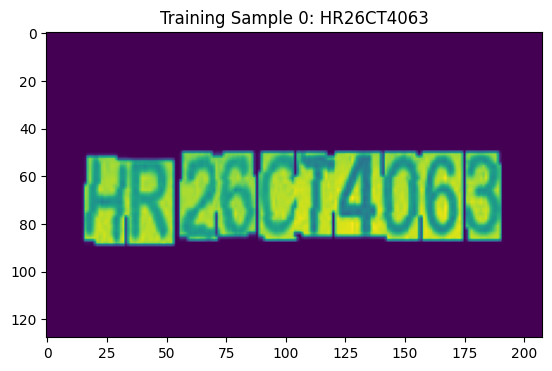

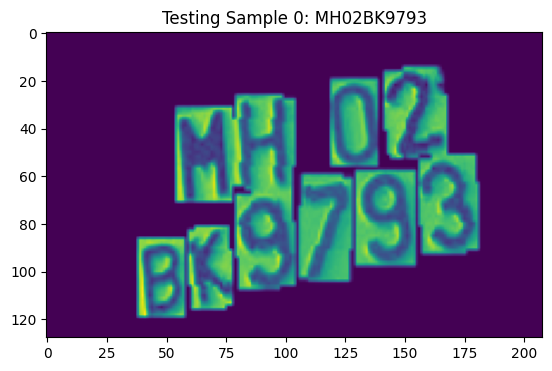

In [11]:
from matplotlib import pyplot as plt

opt = {'path': './dataset/LP-characters', 'imgdir': 'images'}
train_dataset = SynthDataset(opt, train=True)
test_dataset = SynthDataset(opt, train=False)

# Getting the first sample from the training and testing datasets
train_sample = train_dataset[5]
test_sample = test_dataset[5]

# Displaying the first training sample
plt.figure()
imshow(train_sample['augmented_img'], title=f"Training Sample 0: {train_sample['label']}")

# Displaying the first testing sample
plt.figure()
imshow(test_sample['augmented_img'], title=f"Testing Sample 0: {test_sample['label']}")


Checker function to see how the labels look like for debugging purposes, commented out due to its verbose output

In [12]:
'''import numpy as np

# Getting the total number of samples in the dataset
num_samples = len(train_dataset)

train_labels = []

# Iterating through the dataset 
for i in range(num_samples):
    sample = train_dataset[i]
    train_labels.append(sample['label'])

# Getting the unique labels and their counts
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))'''


"import numpy as np\n\n# Getting the total number of samples in the dataset\nnum_samples = len(train_dataset)\n\ntrain_labels = []\n\n# Iterating through the dataset \nfor i in range(num_samples):\n    sample = train_dataset[i]\n    train_labels.append(sample['label'])\n\n# Getting the unique labels and their counts\nunique, counts = np.unique(train_labels, return_counts=True)\nprint(dict(zip(unique, counts)))"

The same changes as previously apply here as well:

Changed the arguments to reflect the new dataset path, the new checkpoint save location, the learn rate and the number of epochs, the last two being for obtaining the best possible performance out of the model.

Besides this I have also changed the alphabet variable, as the prior one was too comprehensive and better suited for general words, while license plates are more standardized, using only upper-case letters and numbers. Dashes are present in the `alphabet` string for the padding purposes later on in the evaluation function.

In [13]:
# Newly defined alphabet, better suited for the task
alphabet = """QWERTYUIOPASDFGHJKLZXCVBNM1234567890-"""

args = {
    'name':'exp2',
    'path':'dataset',
    'imgdir': 'train',
    'imgH':128,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    # Experimented for a bit, the best results are with this lr and this amount of epochs
    'lr':0.001,
    'epochs':70,
    'batch_size':32,
    'save_dir':'checkpoints_carplates_augmented',
    'log_dir':'logs_plates_augmented',
    'resume':False,
    'cuda':False,
    'schedule':False,
    
}

opt = {'path': './dataset/LP-characters', 'imgdir': 'images'}
train_dataset = SynthDataset(opt, train=True)
test_dataset = SynthDataset(opt, train=False)

args['collate_fn'] = SynthCollator()


args['data_train'], args['data_val'] = train_dataset, test_dataset
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train'])*2, len(args['data_val']))*2)
args['alphabet'] = alphabet
model = CRNN(args)


args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)


Traininig Data Size:334
Val Data Size:42Traininig Data Size:334
Val Data Size:42


Epoch: [0]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

checkpoint does not exist
None
Scheduling is False


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s, val_loss=3.93, val_ca=0, val_wa=0]


3.9117201566696167
Validation loss decreased (inf --> 3.911720).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s, val_loss=3.47, val_ca=0, val_wa=0]


3.7004408836364746
Validation loss decreased (3.911720 --> 3.700441).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s, val_loss=3.41, val_ca=0, val_wa=0]


3.6096253395080566
Validation loss decreased (3.700441 --> 3.609625).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s, val_loss=3.37, val_ca=0, val_wa=0]


3.5564211905002594
Validation loss decreased (3.609625 --> 3.556421).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s, val_loss=3.25, val_ca=0, val_wa=0]


3.5030579566955566
Validation loss decreased (3.556421 --> 3.503058).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, val_loss=3.23, val_ca=5, val_wa=0]   


3.4652494390805564
Validation loss decreased (3.503058 --> 3.465249).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, val_loss=3.15, val_ca=4.25, val_wa=0]


3.4268902029309953
Validation loss decreased (3.465249 --> 3.426890).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s, val_loss=3.16, val_ca=5, val_wa=0]   


3.3973321616649628
Validation loss decreased (3.426890 --> 3.397332).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, val_loss=3.11, val_ca=5.11, val_wa=0]


3.3738997909757824
Validation loss decreased (3.397332 --> 3.373900).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, val_loss=3.28, val_ca=6, val_wa=0]   


3.3660629391670227
Validation loss decreased (3.373900 --> 3.366063).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s, val_loss=3.04, val_ca=5.11, val_wa=0]


3.3415802392092617
Validation loss decreased (3.366063 --> 3.341580).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s, val_loss=3.08, val_ca=4.47, val_wa=0]


3.3284498155117035
Validation loss decreased (3.341580 --> 3.328450).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s, val_loss=3.03, val_ca=5.11, val_wa=0]


3.3128091188577504
Validation loss decreased (3.328450 --> 3.312809).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s, val_loss=2.99, val_ca=10, val_wa=0]  


3.292141480105264
Validation loss decreased (3.312809 --> 3.292141).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s, val_loss=3.21, val_ca=8.58, val_wa=0]


3.289440417289734
Validation loss decreased (3.292141 --> 3.289440).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, val_loss=3.05, val_ca=8.58, val_wa=0]


3.278268925845623
Validation loss decreased (3.289440 --> 3.278269).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, val_loss=2.94, val_ca=10.5, val_wa=0]


3.261724394910476
Validation loss decreased (3.278269 --> 3.261724).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s, val_loss=2.91, val_ca=12.5, val_wa=0]


3.24532777733273
Validation loss decreased (3.261724 --> 3.245328).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s, val_loss=2.94, val_ca=9.58, val_wa=0]


3.2298292047099064
Validation loss decreased (3.245328 --> 3.229829).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s, val_loss=2.94, val_ca=10.5, val_wa=0]


3.2158836483955384
Validation loss decreased (3.229829 --> 3.215884).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, val_loss=2.94, val_ca=10.5, val_wa=0]


3.2031029916944957
Validation loss decreased (3.215884 --> 3.203103).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s, val_loss=2.93, val_ca=10.5, val_wa=0]


3.1930995095859873
Validation loss decreased (3.203103 --> 3.193100).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, val_loss=2.95, val_ca=13.7, val_wa=0]


3.1828453177991123
Validation loss decreased (3.193100 --> 3.182845).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, val_loss=2.94, val_ca=8.58, val_wa=0]


3.1735782523949942
Validation loss decreased (3.182845 --> 3.173578).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s, val_loss=2.94, val_ca=11.5, val_wa=0]


3.1649126625061035
Validation loss decreased (3.173578 --> 3.164913).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, val_loss=2.95, val_ca=8.58, val_wa=0]


3.156762861288511
Validation loss decreased (3.164913 --> 3.156763).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s, val_loss=2.96, val_ca=13.7, val_wa=0]


3.1494947009616427
Validation loss decreased (3.156763 --> 3.149495).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s, val_loss=2.97, val_ca=10.5, val_wa=0]


3.142973086663655
Validation loss decreased (3.149495 --> 3.142973).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s, val_loss=3.05, val_ca=10.4, val_wa=0]


3.1395157945567163
Validation loss decreased (3.142973 --> 3.139516).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s, val_loss=2.98, val_ca=7.97, val_wa=0]


3.134751788775126
Validation loss decreased (3.139516 --> 3.134752).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s, val_loss=2.97, val_ca=10.5, val_wa=0]


3.1292487421343402
Validation loss decreased (3.134752 --> 3.129249).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, val_loss=2.95, val_ca=12.7, val_wa=0]


3.1237593181431293
Validation loss decreased (3.129249 --> 3.123759).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, val_loss=2.97, val_ca=10.7, val_wa=0]


3.1189245816433067
Validation loss decreased (3.123759 --> 3.118925).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s, val_loss=3.06, val_ca=9.36, val_wa=0]


3.1167148421792423
Validation loss decreased (3.118925 --> 3.116715).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s, val_loss=2.98, val_ca=14.8, val_wa=0]


3.1124863624572754
Validation loss decreased (3.116715 --> 3.112486).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s, val_loss=2.97, val_ca=12.8, val_wa=0]


3.108629653851191
Validation loss decreased (3.112486 --> 3.108630).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, val_loss=3, val_ca=11.8, val_wa=0]   


3.105395010999731
Validation loss decreased (3.108630 --> 3.105395).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, val_loss=3.01, val_ca=9.58, val_wa=0]


3.1027679537471973
Validation loss decreased (3.105395 --> 3.102768).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s, val_loss=3.02, val_ca=12.6, val_wa=0]


3.100524122898395
Validation loss decreased (3.102768 --> 3.100524).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s, val_loss=3.03, val_ca=11.8, val_wa=0]


3.0985954105854034
Validation loss decreased (3.100524 --> 3.098595).  Saving model ...


Epoch: [40]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.098824282971824
EarlyStopping counter: (-3.098595 1 out of 7)


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s, val_loss=3.12, val_ca=10.5, val_wa=0]


3.098175483090537
Validation loss decreased (3.098595 --> 3.098175).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s, val_loss=3.03, val_ca=11.7, val_wa=0]


3.0965476451918135
Validation loss decreased (3.098175 --> 3.096548).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s, val_loss=3.1, val_ca=8.58, val_wa=0] 


3.096040955998681
Validation loss decreased (3.096548 --> 3.096041).  Saving model ...


Epoch: [44]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.0965419583850435
EarlyStopping counter: (-3.096041 1 out of 7)


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s, val_loss=2.97, val_ca=9.58, val_wa=0]


3.0941584965457087
Validation loss decreased (3.096041 --> 3.094158).  Saving model ...


Epoch: [46]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.0985805988311768
EarlyStopping counter: (-3.094158 1 out of 7)


Epoch: [47]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.0972725500663123
EarlyStopping counter: (-3.094158 2 out of 7)


Epoch: [48]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.095712450085854
EarlyStopping counter: (-3.094158 3 out of 7)


Epoch: [49]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.0945977091789247
EarlyStopping counter: (-3.094158 4 out of 7)


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s, val_loss=3.07, val_ca=12.5, val_wa=0]


3.094059944152832
Validation loss decreased (3.094158 --> 3.094060).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s, val_loss=3.11, val_ca=14.6, val_wa=0]


3.093917440909606
Validation loss decreased (3.094060 --> 3.093917).  Saving model ...


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s, val_loss=3.03, val_ca=10.6, val_wa=0]


3.092792380530879
Validation loss decreased (3.093917 --> 3.092792).  Saving model ...


Epoch: [53]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.093352282488788
EarlyStopping counter: (-3.092792 1 out of 7)


Epoch: [54]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.093199027668346
EarlyStopping counter: (-3.092792 2 out of 7)


Epoch: [55]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.0929857811757495
EarlyStopping counter: (-3.092792 3 out of 7)


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s, val_loss=3.04, val_ca=14.6, val_wa=0]


3.092682307226616
Validation loss decreased (3.092792 --> 3.092682).  Saving model ...


Epoch: [57]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.094092245759635
EarlyStopping counter: (-3.092682 1 out of 7)


Epoch: [58]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.094637814214674
EarlyStopping counter: (-3.092682 2 out of 7)


Epoch: [59]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.095077711343765
EarlyStopping counter: (-3.092682 3 out of 7)


Epoch: [60]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.095696904620186
EarlyStopping counter: (-3.092682 4 out of 7)


Epoch: [61]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.095393823039147
EarlyStopping counter: (-3.092682 5 out of 7)


Epoch: [62]/[100] Training:   0%|          | 0/6 [00:00<?, ?it/s]

3.096956799900721
EarlyStopping counter: (-3.092682 6 out of 7)


Validating: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s, val_loss=3.19, val_ca=11.6, val_wa=0]

3.0983138158917427
EarlyStopping counter: (-3.092682 7 out of 7)
Early stopping


After running the model for 64 epochs with a learning rate of 0.001, it became apparent that the model was simply not converging to an acceptable loss value.

In [14]:
!nvidia-smi

Sat Oct 14 01:14:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:03:00.0 Off |                  N/A |
|  0%   56C    P8              17W / 250W |    166MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
torch.cuda.empty_cache()

In [16]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [17]:
def get_accuracy(args, char_to_int):
    device = torch.device("cuda:2")
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model = model.to(device)  # Move the model to cuda:2
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, augmented_input, targets = batch['img'].to(device), batch['augmented_img'].to(device), batch['label']
        
        # Concatenate original and augmented images along the batch dimension
        input_combined = torch.cat((input_, augmented_input), dim=0)
        
        # Duplicate the targets for the augmented images
        targets_combined = targets + targets
        
        images.extend(input_combined.squeeze().detach())  # Now extending with combined images
        labels.extend(targets_combined)  # Now extending with combined targets
        
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        print(f'Batch {iteration + 1} Predictions: {sim_preds}')
        
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = images[i]
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img.cpu() * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    
    true_labels = []
    pred_labels = []

    for true_label, pred_label in zip(labels, predictions):
        true_chars = [char for char in true_label if char in char_to_int]
        pred_chars = [char for char in pred_label if char in char_to_int]

        # Finding the maximum length between the two sequences
        max_length = max(len(true_chars), len(pred_chars))

        # Padding the shorter sequence with a dash ('-')
        true_chars_padded = true_chars + ['-'] * (max_length - len(true_chars))
        pred_chars_padded = pred_chars + ['-'] * (max_length - len(pred_chars))

        # Converting characters to integers and appending to lists
        true_labels.append([char_to_int[char] for char in true_chars_padded])
        pred_labels.append([char_to_int[char] for char in pred_chars_padded])

    # Flattening the lists for compatibility with sklearn metrics
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    flat_pred_labels = [item for sublist in pred_labels for item in sublist]

    accuracy = accuracy_score(flat_true_labels, flat_pred_labels)
    precision = precision_score(flat_true_labels, flat_pred_labels, average='weighted', zero_division = 0)
    recall = recall_score(flat_true_labels, flat_pred_labels, average='weighted', zero_division = 0)
    f1 = f1_score(flat_true_labels, flat_pred_labels, average='weighted')

    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    
    return ca, wa, accuracy, precision, recall, f1

  0%|          | 0/2 [00:00<?, ?it/s]

Loading model checkpoints_carplates_augmented/exp2/best.ckpt


100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

Batch 1 Predictions: ['TN7', 'HR26D', 'KL0', 'KL3', 'HR25', 'MH25', 'MH20', 'MH0', 'MH2', 'KL1', 'TN4A', 'KL0', 'MH2', 'ML1', 'DL0', 'H26', 'MH1', 'KL1', 'MH126', 'TN7', 'MH25', 'MH14', 'MH24', 'MH2', 'MH1', 'MH26D', 'MH27', 'MH2', 'KL2', 'KL25', 'MH12', 'MH07']
Batch 2 Predictions: ['KL104', 'MH14', 'MH25', 'MH25', 'MH24', 'MH2', 'MH0', 'TN2', 'MH2', 'TNH4']


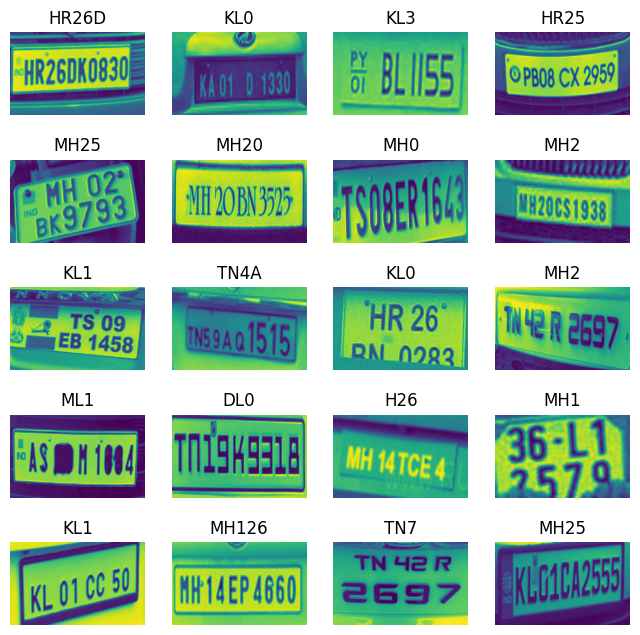

Character Accuracy: 20.45
Word Accuracy: 0.00
Accuracy: 0.13
Precision: 0.21
Recall: 0.13
F1 Score: 0.14


In [19]:
char_to_int = {char: idx for idx, char in enumerate(alphabet)}

args['imgdir'] = 'test'
args['data'] = test_dataset
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')

if os.path.isfile(resume_file):
    print('Loading model %s' % resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'])
    args['model'] = model
    
    # Call the updated get_accuracy function
    ca, wa, accuracy, precision, recall, f1 = get_accuracy(args, char_to_int)
    
    # Print all the metrics
    print(f"Character Accuracy: {ca:.2f}")
    print(f"Word Accuracy: {wa:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
else:
    print("=> no checkpoint found at '{}'".format(save_file))
    print('Exiting')


- In summary, there's a notable improvement in the model's performance, although it's yet to reach a usable state. Specifically, a 5% increase in character prediction accuracy is observed in the enhanced model compared to the prior version.
- The improvement is also mirrored in other accuracy metrics computed:
  - **sklearn Accuracy Score:** 3% increase
  - **Precision Score:** 4% increase
  - **Recall Score:** 3% increase
  - **F1 Score:** 2% increase, indicating a similar magnitude of improvement as compared to the previous architecture.
- Despite the advancements, the model's performance remains suboptimal. However, a modest improvement is discernible.
- Potential further enhancements include:
  - Incorporating a weighting mechanism based on the characters' distribution within the dataset.
  - Employing a dual model architecture, where a standalone character prediction model operates in tandem with the sequence predictor to generate the final predictions.